---
### COMS 4735 - Visual Interfaces to Computer Systems
# Facial Analysis Report
---
*Generated by Catherine Zhao, Shalva Kohen*
*Final Project*

## Abstract
The objective of this report is to analyze which how a specific user categorize faces by attractive and unattractiveness. This is done by analyzing different factors of the face such as eye color, face ratios, facial hair, gender, and age. This report allows a user to create a customize report that specifies the preferances on how attractive faces are.

The *introduction* provides a description of the data set, and a detailed walk-through of all initial findings from data exploration. The *method* section highlights the statistical analyses utilized to model wether or not a face a attractive. Then the *analysis* section desribes the results as shown from the method section. Finally, the *conclusion* section summarizes the key research findings about the specific user preferance. 

In summary, our report gives insite to the user on his or her preferance on attractiveness. 

## Introduction

In this project, the user is asked to rate 147 images of men and women from a scale of 1 to 5. The images were used from a single databse(https://areeweb.polito.it/ricerca/cgvg/siblingsDB.html). These images were taken from an Italian university, there are some similarities between all the faces. For example, all the people in the database have a white skin tone. Therefore, users should be aware that their results are only true in the context of this database. The images were initially analyzed using computer vision method to extract key features.Using a random seed of 42, a sample of 124 observations out of 147 was selected to train the user's preferance on attractiveness. The remaining 23 data were used for model evaluation and testing.

The data comprises both numerical and categorical variables. The following contains the extracted features. 


In [1]:
column_full_name = ["Sex", "Age", "Eye Color", "Facial Hair", "Face ratios", \
                    "rt_1: Hairline : Eyebrow top : Eye top", \
                    "rt_2: Eye pupil : Nose flair : Nose bottom", \
                    "rt_3: Eye pupil : Nose bottom : Mouth", \
                    "rt_4: Eye pupil : Nose bottom : Chin", \
                    "rt_5: Eye pupil : Mouth : Chin", \
                    "rt_6: Face side : Eyebrows : Face side", \
                    "rt_7: Face side : Eye inside : Face side", \
                    "rt_8: Face side : Nose width : Face side", \
                    "rt_9: Face side : Eye outside : Nose center on the left side", \
                    "rt_10: Face side : Eye outside : Nose center on the right side", \
                    "rt_11: Eye outside : Eye inside : Nose center on the left side", \
                    "rt_12: Eye outside : Eye inside : Nose center on the right side", \
                    "rt_13: Mouth outside : Lip cupid’s bow : Mouth outside", \
                    "rt_14: Vertical Ratio", \
                    "rt_15: Horizontal Ratio"]
column_full_name

['Sex',
 'Age',
 'Eye Color',
 'Facial Hair',
 'Face ratios',
 'rt_1: Hairline : Eyebrow top : Eye top',
 'rt_2: Eye pupil : Nose flair : Nose bottom',
 'rt_3: Eye pupil : Nose bottom : Mouth',
 'rt_4: Eye pupil : Nose bottom : Chin',
 'rt_5: Eye pupil : Mouth : Chin',
 'rt_6: Face side : Eyebrows : Face side',
 'rt_7: Face side : Eye inside : Face side',
 'rt_8: Face side : Nose width : Face side',
 'rt_9: Face side : Eye outside : Nose center on the left side',
 'rt_10: Face side : Eye outside : Nose center on the right side',
 'rt_11: Eye outside : Eye inside : Nose center on the left side',
 'rt_12: Eye outside : Eye inside : Nose center on the right side',
 'rt_13: Mouth outside : Lip cupid’s bow : Mouth outside',
 'rt_14: Vertical Ratio',
 'rt_15: Horizontal Ratio']

A more detail report on how each feature was extracted in the project report. 

### Data Obervations
Initially, a summary table and histogram for the features and labels were used to give an overview of the data and to create an initial understand of the data. 

In [91]:
import pandas as pd
import numpy as np
import sys
import os
import cv2

import plotly.plotly as py
import plotly.graph_objs as go

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
from sklearn.ensemble import RandomForestRegressor
import plotly
import tabulate

plotly.tools.set_credentials_file(username='caz2114', api_key='UVYVtmcj7I0sWCn6Rkhk')


In [3]:
df = pd.read_csv("subject_data.csv")
df = df[(df.color_1 != 0) | (df.color_2 != 0) | (df.color_3 != 0)]
# cleaning sex into bitmap type
df["sex"] = df["sex"].astype('category')
dummies = pd.get_dummies(df['sex'])
df = pd.concat([df, dummies], axis=1)
df = df.drop(['M'],axis = 1)

colnames = df.columns.tolist()
colnames = colnames[:2] + colnames[3:] + [colnames[2]]
df = df[colnames]

target = pd.read_csv("./user_data/"+"Heidi.csv")
target = target.sort_values(["img_file"])
target.index = range(len(target))

target_logit = target.copy()
target_logit[' score']=target_logit[' score'].replace(1,'0')
target_logit[' score']=target_logit[' score'].replace(2,'0')
target_logit[' score']=target_logit[' score'].replace(3,'1')
target_logit[' score']=target_logit[' score'].replace(4,'1')
target_logit[' score']=target_logit[' score'].replace(5,'1')
target_logit[' score'] = target_logit[' score'].astype('uint8')

In [4]:
df.describe()

,n,color_1,color_2,color_3,rt_1,rt_2,rt_3,rt_4,rt_5,rt_6,...,rt_9,rt_10,rt_11,rt_12,rt_13,rt_14,rt_15,f_hair,F,age
count,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,...,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000
mean,124.571429,108.561062,89.860909,78.380404,1.721321,1.202059,1.932472,0.654297,1.510863,0.896070,...,1.785742,1.630910,1.256088,1.200458,0.865339,0.386297,0.455425,0.367347,0.428571,24.768707
std,74.846967,23.333787,24.361388,25.004460,0.342646,0.199470,0.227898,0.078896,0.184953,0.260805,...,0.275258,0.205575,0.132226,0.122901,0.381367,0.025486,0.017331,0.483730,0.496564,10.206812
min,1.000000,59.694004,43.674020,31.200980,1.025456,0.633811,1.473135,0.478704,1.036290,0.319948,...,1.201508,1.157918,1.002083,0.990640,0.159755,0.319590,0.402833,0.000000,0.000000,3.000000
25%,59.500000,90.894098,69.557208,58.484418,1.492626,1.080334,1.760491,0.595787,1.372220,0.721525,...,1.581981,1.478467,1.171405,1.118191,0.605402,0.370526,0.444883,0.000000,0.000000,20.000000
50%,122.000000,105.102941,88.397647,73.984127,1.721690,1.183771,1.915279,0.647842,1.518239,0.874852,...,1.755419,1.613452,1.241321,1.182832,0.821064,0.388733,0.456176,0.000000,0.000000,23.000000
75%,189.000000,123.917483,106.041195,97.282129,1.898545,1.321024,2.102804,0.714480,1.644818,1.052614,...,1.960330,1.755997,1.317821,1.272762,1.090166,0.404871,0.466591,1.000000,1.000000,26.000000
max,269.000000,167.191373,146.715686,137.813725,2.778463,1.732699,2.549525,0.838288,2.024423,1.999409,...,2.631189,2.228192,2.037041,1.836800,2.126056,0.447482,0.494740,1.000000,1.000000,76.000000


In [5]:
df_var = df.iloc[:,2:]
res_var = target.iloc[:,1]

In [6]:
# histogram of all variable in the data
cf.set_config_file(offline=False, world_readable=True, theme='pearl')
import plotly
plotly.offline.init_notebook_mode(connected=True)
df_var.iplot(kind='histogram', subplots=True, shape=(5, 5), filename='histogram-subplots')

The histograms shows the general distribution for all the variables. Most variables seem follow a normal distribution with the exception of 
* rt_1: Hairline : Eyebrow top : Eye top
* rt_7: Face side : Eye inside : Face side
* rt_8: Face side : Nose width : Face side
* rt_14: Vertical Ratio

To verify these oberservations, a box plot was used to see the overall distribution of the features. 

In [7]:
df_var.iplot(kind='box', subplots=True, boxpoints = 'outliers', shape=(5, 5), filename='boxplot-subplots')

From the boxplot, we can verify our supicions of the right skew. Understanding the general distribution in the raw data is important for determining what type of model to fit. 

Then we analyzed how the specfic user's overalle distribution of their ratings. First we analyzed the raw input. 

In [8]:
res_var.describe()

count    147.000000
mean       2.578231
std        0.971689
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name:  score, dtype: float64

In [ ]:
from IPython.display import display, Markdown
size = res_var.groupby(res_var).size().as_matrix()


display(Markdown("The maximum for the user's rating is a " + str(res_var.max())+ \
                 ". The lowest rating is a " +  str(res_var.min())+". The most common rating is "+\
                 str(np.argmax(size)+1) +" and the average is "+ str(round(res_var.mean(),2)) + "."))

Then we categorized the raw input from the user. The labeling method was if a user labeled 3 or higher if was labeled as attractive or 1. All other values were labeled as unattractive or 0. The following is a summary chart. 

In [29]:
target_logit.iloc[:,1].describe()

count    147.000000
mean       0.530612
std        0.500768
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name:  score, dtype: float64

In [32]:
ave = target_logit.iloc[:,1].mean()
if ave < 0.5:
    display(Markdown("The average for this user is " + str(round(ave,2)) + " which is majority not attractive."+\
                    "We then used the histogram to observe the general trends."))
elif ave > 0.5:
    display(Markdown("The average for this user is " + str(round(ave,2)) + " which is majority attractive."+\
                    "We then used the histogram to observe the general trends."))
else:
    display(Markdown("The average for this user is " + str(round(ave,2)) + " which means the user has no preference."+\
                    "We then used the histogram to observe the general trends."))
    

res_var.iplot(kind='histogram', 
              layout = {'title':"Histogram for User Rating", 
                        'xaxis':dict(
                        title='Rating Scale'),
                        'yaxis':dict(
                        title='Frequency')},
              filename='Catherine')

The average for this user is 0.53 which is majority attractive.We then used the histogram to observe the general trends.

The data appears normally distributed. This suggests that linear regression may be an appropriate model to fit to the data.

The next step was to use a correlation plot to gain an understanding of correlation between the variables in the data set and how multicollinearity may effect the model.

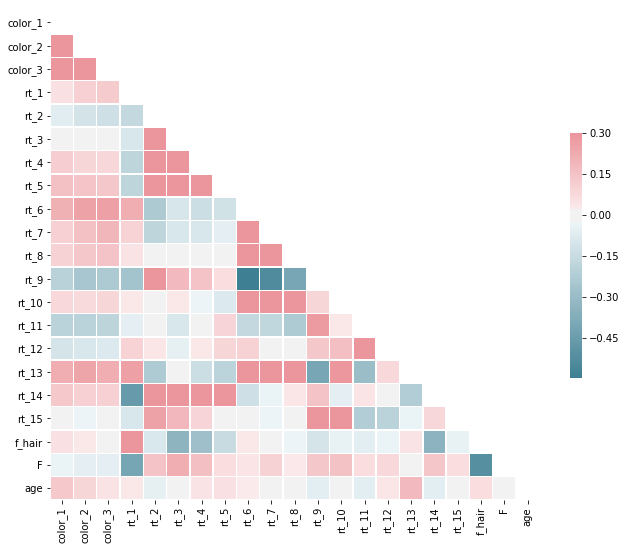

In [10]:
# correlation plot for variables
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
corr = df_var.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Based on the correlation plot, there is no extreme corrlation that might suggest that variables corresponded to each other. This suggest that all variable have significance. 

## Methods

In order to generate a robust method for determine attractivness of a user, five different models were used to categorize the data, these include multiple linear regression, logic regression, ADAboost decision tree, support vector machine, and neural networks. After each model labels the testing data, a simple voting strategy was used to produce an overall model. 

As detailed in the introduction, we used 21 variables from the data set to serve as the initial predictor variables in the full model. We also using a training sample size of 124 to test on a sample size of 23 images. For the testing, multiple linear regression used the raw input, where as the other models used a labeling method which labeled all values above and equal to 3 as attractive, and below a 3 as not attractive.  

### Multiple Linear Regression
Since there was no highly correlated variables in the correlation plot, multicollinearity was not warranted. The full model was used because the reduce model produced significant poorer results. The following is the regression results. 

In [11]:
## Getting the training and testing set for linear regression
y = target.iloc[:,1]
X_full = df.iloc[:,2:]

size = 0.15

#linear
train_features_lm, test_features_lm, train_labels_lm, test_labels_lm = train_test_split(X_full, y, test_size = size, random_state = 42)

#logic and ADA
y = target_logit.iloc[:,1]
train_features, test_features, train_labels, test_labels = train_test_split(X_full, y, test_size = size, random_state = 42)

In [12]:
#full model
lm_full = sm.OLS(list(train_labels_lm), train_features_lm).fit()
lm_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     43.51
Date:                Wed, 09 May 2018   Prob (F-statistic):           9.19e-42
Time:                        21:25:21   Log-Likelihood:                -156.61
No. Observations:                 124   AIC:                             355.2
Df Residuals:                     103   BIC:                             414.4
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
color_1        0.0331      0.014      2.332      0.022       0.005       0.061
color_2       -0.0656      0.027     -2.472      0.015      -0.118      -0.013
color_3        0.0358      0.016      2.206      0.030       0.004       0.068
rt_1          -0.0966      0.396     -0.244      0.808      -0.881       0.688
rt_2          -0.0009      0.653     -0.001      0.999      -1.296       1.294
rt_3          -3.2842      3.397     -0.967      0.336     -10.022       3.453
rt_4          16.5339     17.982      0.919      0.360     -19.130      52.198
rt_5          -5.0228      5.236     -0.959      0.340     -15.407       5.361
rt_6          -0.3396      1.205     -0.282      0.779      -2.730       2.051
rt_7          -0.3279      0.385     -0.851      0.397      -1.092       0.436
rt_8           0.0489      0.149      0.328      0.744      -0.247       0.345
rt_9          -1.1421      0.791     -1.444      0.152      -2.711       0.427
rt_10         -0.4684      1.157     -0.405      0.686      -2.762       1.825
rt_11         -0.3617      1.268     -0.285      0.776      -2.877       2.154
rt_12          1.2302      1.307      0.941      0.349      -1.362       3.822
rt_13          0.2017      0.326      0.619      0.537      -0.444       0.848
rt_14         -0.8556      8.341     -0.103      0.918     -17.398      15.687
rt_15         17.3837     10.360      1.678      0.096      -3.163      37.931
f_hair        -0.3913      0.258     -1.519      0.132      -0.902       0.120
F              0.3338      0.242      1.381      0.170      -0.146       0.813
age           -0.0052      0.009     -0.585      0.560      -0.023       0.012
==============================================================================
Omnibus:                        1.555   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.460   Jarque-Bera (JB):                1.316
Skew:                           0.073   Prob(JB):                        0.518
Kurtosis:                       2.517   Cond. No.                     4.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Given multiple linear regression was used to fit the model, normality of error terms and non-constant variance of error terms must be checked in the final model. For each variable, the residual plot was ploted, as shown below. 

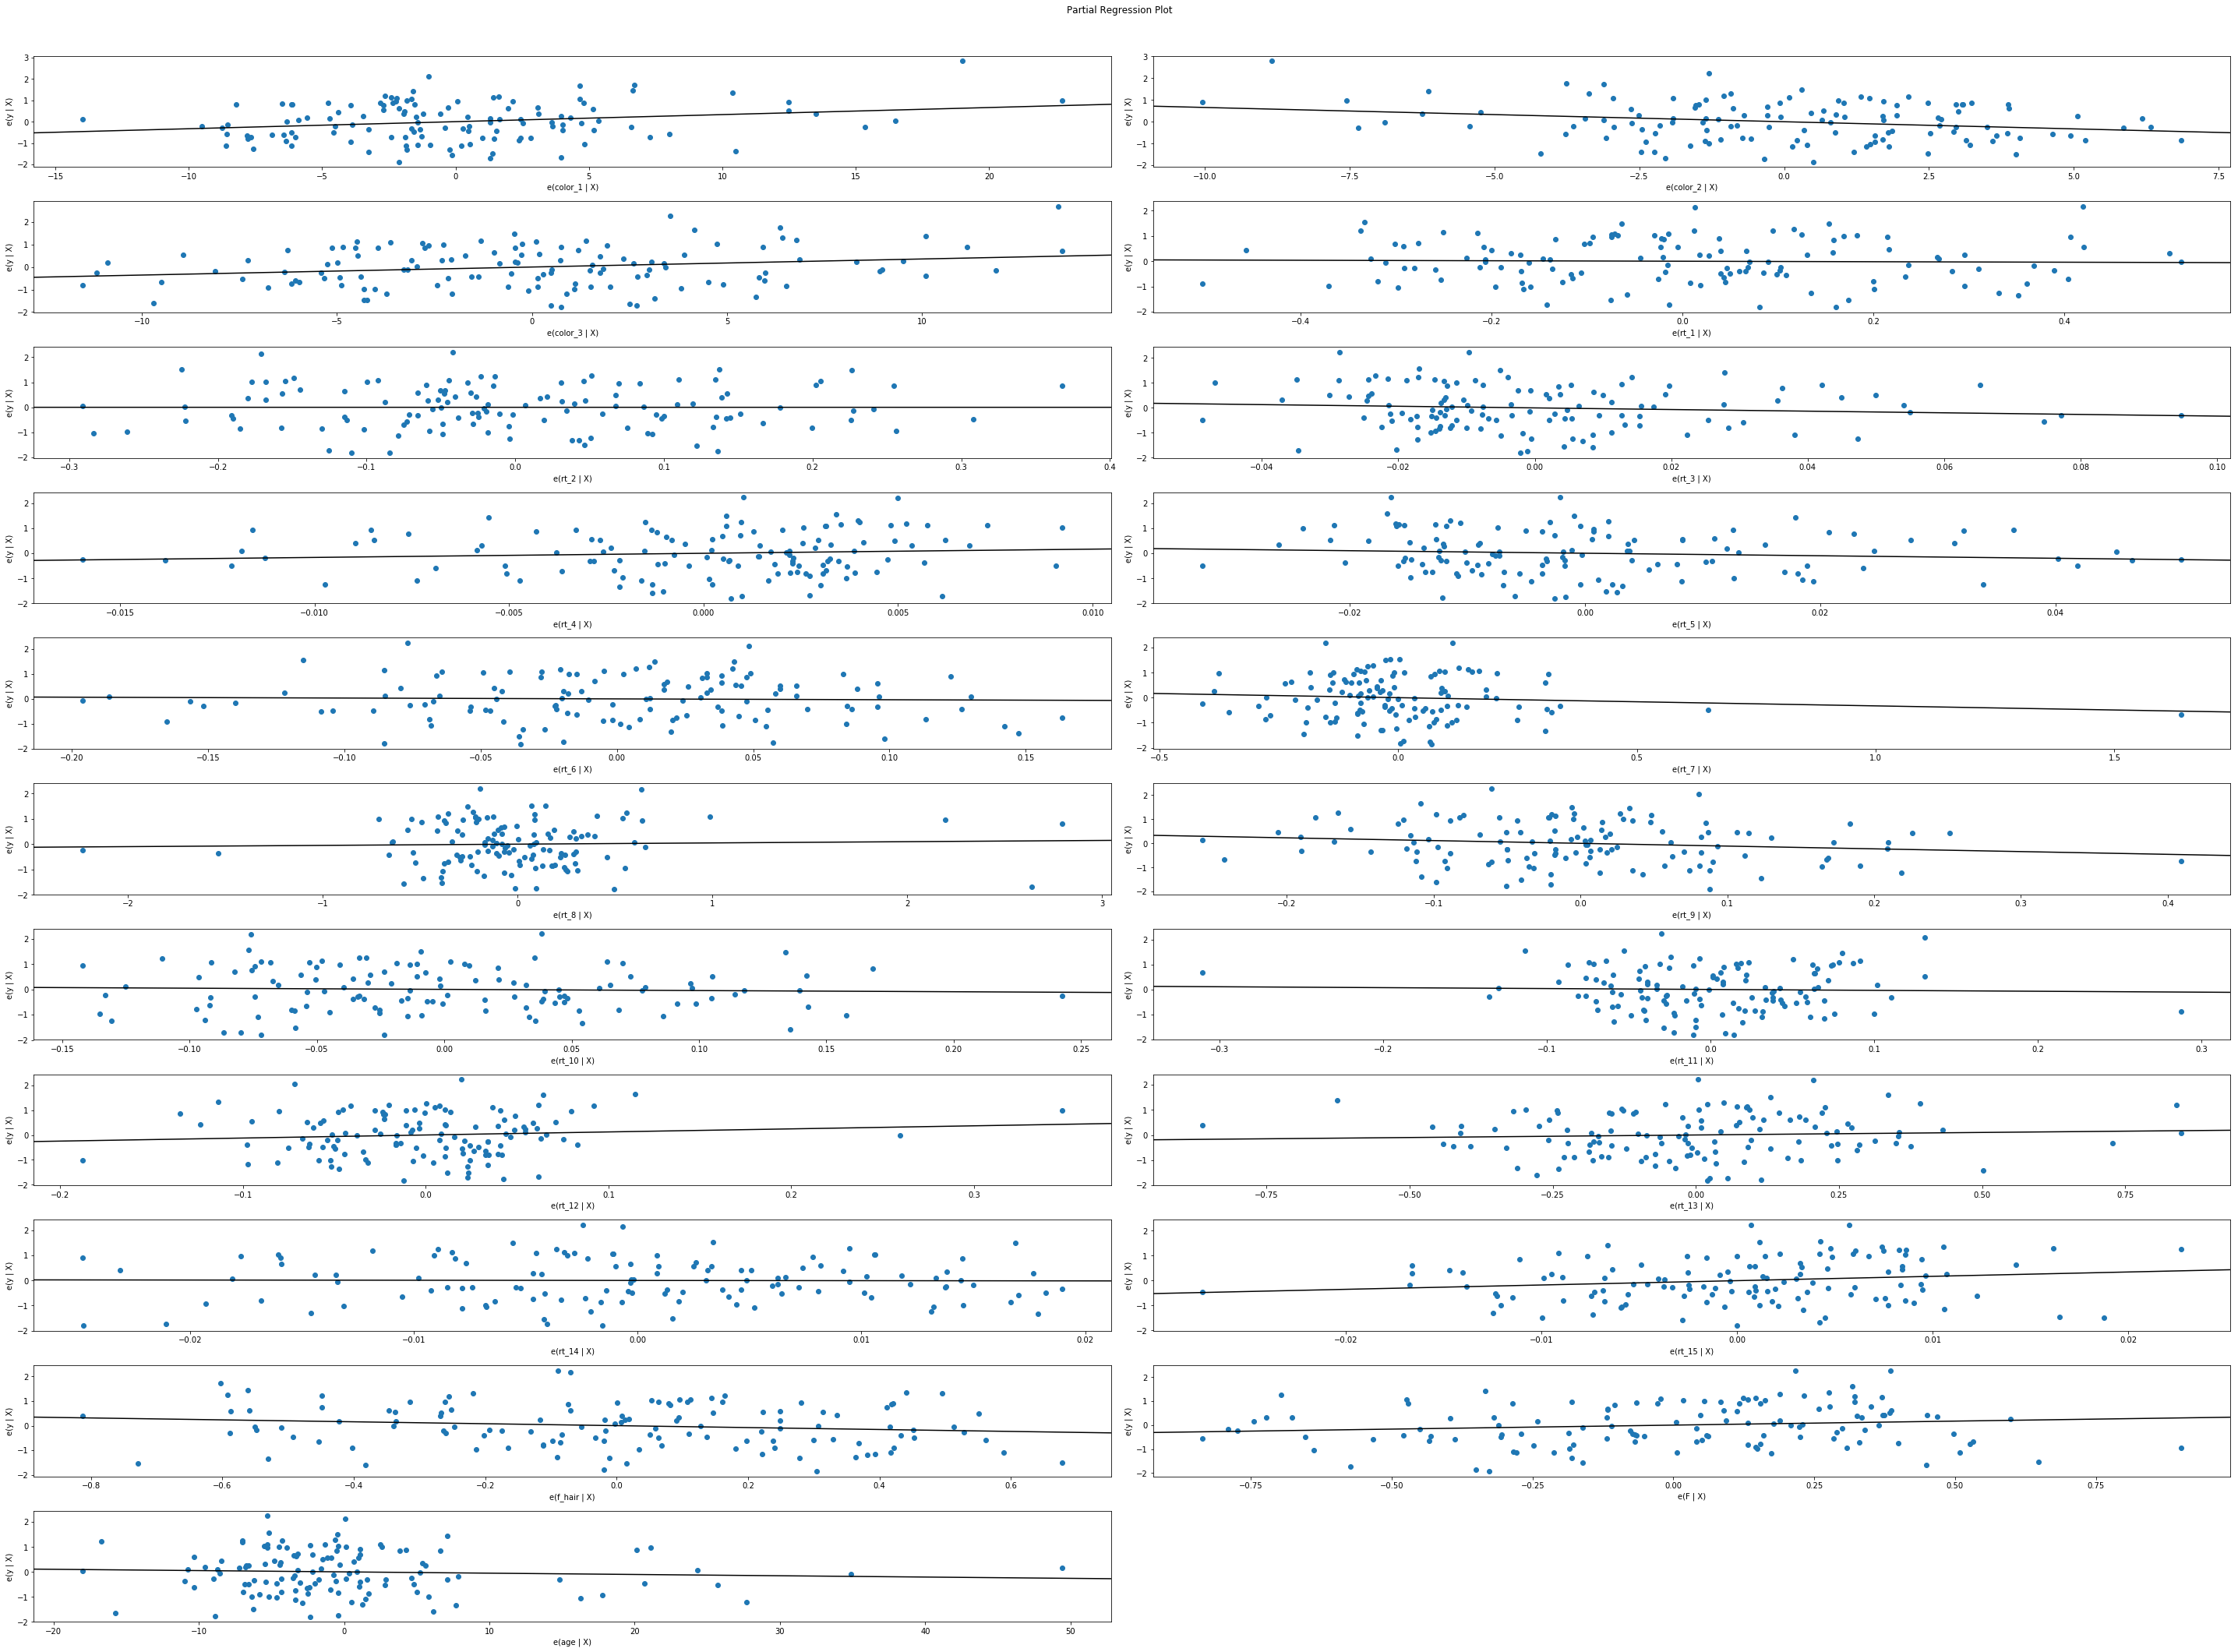

In [13]:
# we fail to reject the null hypothesis and use the full model
fig = plt.figure(figsize=(40,30))
fig = sm.graphics.plot_partregress_grid(lm_full, fig=fig)

The residual plot shows non-constant variance for every variable of the residuals hence confirming linearity of the model. Next, the QQ norm was ploted. 

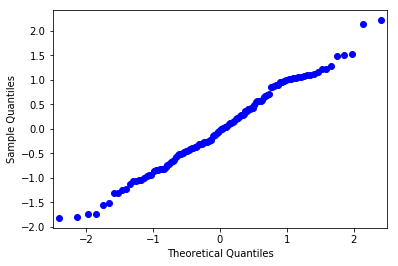

In [14]:
qq_norm = sm.qqplot(lm_full.resid)

The QQ-norm was approximately a straight line indicating normality in the model. Lastly the residual plot against the testing sample was plotted which also showed similar normality in the model. 
[PLOT THE REGRSSION MODEL]

### Logistic Regression
After converting the labels to become categorical, we were able to use logistic regression. In statistics, logistic regression or logit regression is a model where the dependent vairable is a categorical value. In this case either attractive or unattractive. Since we only have 2 outcomes, we used a single logit regression. We used the logistic model from the package statmodel where it performs logistic regression. The results are shown below. 

In [15]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

logit_full = sm.Logit(list(train_labels), train_features).fit()
logit_full.summary()

Optimization terminated successfully.
         Current function value: 0.622623
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  124
Model:                          Logit   Df Residuals:                      103
Method:                           MLE   Df Model:                           20
Date:                Wed, 09 May 2018   Pseudo R-squ.:                  0.1017
Time:                        21:25:24   Log-Likelihood:                -77.205
converged:                       True   LL-Null:                       -85.950
                                        LLR p-value:                    0.6210
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
color_1        0.0631      0.033      1.908      0.056      -0.002       0.128
color_2       -0.1309      0.062     -2.108      0.035      -0.253      -0.009
color_3        0.0716      0.038      1.904      0.057      -0.002       0.145
rt_1          -0.5509      0.898     -0.613      0.540      -2.312       1.210
rt_2           0.4169      1.503      0.277      0.781      -2.529       3.363
rt_3          -3.2837      7.858     -0.418      0.676     -18.685      12.118
rt_4          13.1591     41.519      0.317      0.751     -68.217      94.535
rt_5          -1.2502     12.020     -0.104      0.917     -24.808      22.308
rt_6          -0.0298      2.830     -0.011      0.992      -5.576       5.517
rt_7          -1.2567      1.002     -1.254      0.210      -3.221       0.707
rt_8           0.5075      0.383      1.324      0.186      -0.244       1.259
rt_9          -2.2938      1.864     -1.230      0.219      -5.948       1.360
rt_10         -0.3938      2.695     -0.146      0.884      -5.676       4.889
rt_11         -0.6326      2.975     -0.213      0.832      -6.463       5.198
rt_12          1.2324      2.986      0.413      0.680      -4.620       7.085
rt_13          0.6444      0.760      0.848      0.397      -0.845       2.134
rt_14        -20.5886     19.594     -1.051      0.293     -58.993      17.816
rt_15         25.4029     24.624      1.032      0.302     -22.859      73.665
f_hair        -0.7580      0.601     -1.262      0.207      -1.935       0.419
F              0.7263      0.545      1.334      0.182      -0.341       1.794
age           -0.0062      0.020     -0.311      0.756      -0.046       0.033
==============================================================================
"""

No addition procedures were done to the model. 

### Adaboost Descision Tree
The next type of model was Adaboost decision tree. This is a machine learning technique with the base model of a decision tree. A decision tree is a tree model where the resultant class labels are discrete. In this case attractive or unattractive. In addition adaboost or adaptive boosting was used to prevent overfitting. Overfitting is very common in decision trees because with increase number of branches the more likely it will converge with the test model. By using adaboosting, a subset of the training sample is used to test the algorithm itselt to understand what kind of training points are performing the worst. The final resultant model goes is a more rebust model. 

Decision trees was used because it perform well under non-linear models. There is also no tuning required for a decision tree. There are also reseaonably fast to train and classify. The following is the parameters for the adaboost decision tree. 

In [16]:
from sklearn.ensemble import AdaBoostClassifier
# for i in [1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,1000]:
clf = AdaBoostClassifier(n_estimators=40)
clf.fit(train_features,train_labels)

# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
# dot_data = StringIO()
# export_graphviz(clf, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=40, random_state=None)

### Support Vector Machine
The next classification technique was support vector machine. This model was used because it guaranteed optimal convergence. Since our data is multidimensional, we used a kernel function. This was applied with the sklearn's package svm function. The follwoing is the paraters for th support vector machine decision tree. 

In [17]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', probability=True)

svm.fit(train_features,train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Neural Network
The last type of model we ran was neural network. This type of method was the most complex model we tested. 

In [18]:
# https://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html/2
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(train_features)

# Now apply the transformations to the data:
X_train = scaler.transform(train_features)

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

mlp.fit(X_train, train_labels)


/Users/caz2114/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

## Results

In [19]:
display(Markdown("After all the model were trained, we retrieved the results for each model. "+\
                 "For the linear regression model, since the results were not categorized, "+\
                 "we used the average of the trained data as the threshhold for attractiveness. "+\
                 "If the result was above the average, then the point will be labeled as 1 for attractive."+\
                 "For this user, the average was "+str(round(np.mean(train_labels_lm),2)) + \
                 ". For each testing data, five results were produced. The following is the accuracy of each model."
                ))

After all the model were trained, we retrieved the results for each model. For the linear regression model, since the results were not categorized, we used the average of the trained data as the threshhold for attractiveness. If the result was above the average, then the point will be labeled as 1 for attractive.For this user, the average was 2.52. For each testing data, five results were produced.

In [50]:
actual = test_labels.as_matrix()

#linear Regression
thresh_lm = np.mean(train_labels_lm)

#full model
test_feat_lm_red = test_features
y_pred_lm = lm_full.predict(test_feat_lm_red)

y_pred_lm = y_pred_lm.as_matrix()
y_pred_lm[y_pred_lm <= thresh_lm] = 0
y_pred_lm[y_pred_lm > thresh_lm] = 1
y_pred_lm = y_pred_lm.astype("uint8")
acc_lm = np.sum(y_pred_lm==actual)/len(actual)

print("Multiple Linear Regression: ", round(acc_lm,2))

#logit
thresh_logit = 0.5
y_pred_logit = logit_full.predict(test_features)

y_pred_logit = y_pred_logit.as_matrix()
# print(y_pred_logit)
y_pred_logit[y_pred_logit <= thresh_logit] = 0
y_pred_logit[y_pred_logit > thresh_logit] = 1
y_pred_logit = y_pred_logit.astype("uint8")
acc_logit = np.sum(y_pred_logit==actual)/len(actual)
print("Logit:", round(acc_logit,2))

#ADAboost random forest
y_pred_ada = clf.predict(test_features)
y_pred_ada = y_pred_ada.astype("uint8")
acc_ada = np.sum(y_pred_ada==actual)/len(actual)
print("Adaboost Random Forest:", round(acc_ada,2))

#Neural Networks
test_features_nn = scaler.transform(test_features)
y_pred_nn = mlp.predict(test_features_nn)
acc_nn = np.sum(y_pred_nn==actual)/len(actual)
print("Neaural Networks: ", round(acc_nn,2))

#Support Vector Machine
y_pred_svm = svm.predict(test_features)
acc_svm = np.sum(y_pred_svm==actual)/len(actual)
print("Support Vector Machine: ", round(acc_svm,2))



Multiple Linear Regression:  0.61
Logit: 0.52
Adaboost Random Forest: 0.65
Neaural Networks:  0.48
Support Vector Machine:  0.7


The following contains a visual representation for the result. The gray represent attractive according to the model, and black represents not attractive. 

In [51]:
prediction = np.array([y_pred_lm,
                       y_pred_logit,
                       y_pred_ada,
                       y_pred_nn,
                       y_pred_svm])

py.iplot([{'z':prediction,
           'type':'heatmap',
           'y':['Linear', 'Logit', 'ADA','NN','SVM'],
           'colorscale': [
               [0, 'rgb(0, 0, 0)'],
               [0.5, 'rgb(0, 0, 0)'],
               [0.5, 'rgb(200, 200, 200)'],
               [1.0, 'rgb(200, 200, 200)']]
}], filename='basic-heatmap')

Since all the model performed with a variety of results, we took a voting strategy. Each image voted wether or not was attractive. Then based on majority vote, the image will determine if it was attractive or not attractive. Since there were 5 models there was no tie. The following is a visual representation of the vote. The actual row represent what the user finds attractive, and the predicted row shows what the model predicted as attractive. 

In [71]:
final = (y_pred_lm)+\
        (y_pred_logit)+\
        (y_pred_ada)+\
        (y_pred_nn)+\
        (y_pred_svm)

final_raw = final.copy()
final[final <= 2] = 0
final[final > 2] = 1
print(final)
print(actual)
acc_final = np.sum(final==actual)/len(actual)
print("Final:", acc_final)

[1 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0]
[1 1 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1]
Final: 0.6956521739130435


In [67]:

py.iplot([{'z':[final,actual],
           'type':'heatmap',
           'y':["Predicted","Actual"],
           'colorscale': [
               [0, 'rgb(0, 0, 0)'],
               [0.5, 'rgb(0, 0, 0)'],
               [0.5, 'rgb(200, 200, 200)'],
               [1.0, 'rgb(200, 200, 200)']]
}], filename='basic-heatmap')

[1 1 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 0]
[1 1 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1]
Final: 0.6521739130434783


In [65]:
display(Markdown("The final model performed with a "+str(round(acc_final,2))+"."))

The final model performed with a 0.65.

The following is a detail breakdown on how each model performed. 

In [61]:

from sklearn.metrics import classification_report,confusion_matrix
print("\nFinal Model\n",classification_report(actual,final))

print("\nMultiple Linear Regression\n",classification_report(actual,y_pred_lm))

print("\nLogistic Regression\n",classification_report(actual,y_pred_logit))

print("\nAdaboost Decision Tree\n",classification_report(actual,y_pred_ada))

print("\nNeural Networks\n",classification_report(actual,y_pred_nn))

print("\nSupport Vector Machine\n",classification_report(actual,y_pred_svm))



Final Model
              precision    recall  f1-score   support

          0       0.46      0.86      0.60         7
          1       0.90      0.56      0.69        16

avg / total       0.77      0.65      0.66        23


Multiple Linear Regression
              precision    recall  f1-score   support

          0       0.42      0.71      0.53         7
          1       0.82      0.56      0.67        16

avg / total       0.70      0.61      0.62        23


Logistic Regression
              precision    recall  f1-score   support

          0       0.36      0.71      0.48         7
          1       0.78      0.44      0.56        16

avg / total       0.65      0.52      0.53        23


Adaboost Decision Tree
              precision    recall  f1-score   support

          0       0.46      0.86      0.60         7
          1       0.90      0.56      0.69        16

avg / total       0.77      0.65      0.66        23


Neural Networks
              precision    recall

Based on the results, we isolated the worse performing image and displayed them below.

In [87]:
false_pos = []
fal_pos_cnt = []
false_neg = []
fal_neg_cnt = []

diff = final==actual
for i in range(len(final)):
    if not diff[i]:
        if actual[i]:
            # actual positive, we predicted negative
            false_neg.append(test_labels.index[i])
            fal_neg_cnt.append(final_raw[i])
        else:
            # actual negative, we predicted positive
            false_pos.append(test_labels.index[i])
            fal_pos_cnt.append(final_raw[i])

print(false_neg)
print(fal_neg_cnt)
print(false_pos)
print(fal_pos_cnt)

# Getting worse performing images
# worst_f_n = np.argwhere(fal_neg_cnt == np.amax(fal_neg_cnt))
# worst_f_p = np.argwhere(fal_pos_cnt == np.amax(fal_pos_cnt))


[12, 81, 18, 36]
[1, 0, 0, 1]
[26, 134, 66]
[2, 2, 3]
[[0]
 [3]]
[[2]]
